In [1]:
import os
import math
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [37]:
## convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('var{}(t-{})'.format(j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('var{}(t+{})'.format(j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}".format(name), row, True) 
        i += 1
    return plot_df

def get_eval(y, yhat):
    print("MSE: {}".format(mean_squared_error(y,yhat)))
    print("MAE: {}".format(mean_absolute_error(y,yhat)))
    print("r2_score: {}".format(r2_score(y,yhat, multioutput = "variance_weighted")))

In [3]:
train = pd.read_csv("../data/train_nocat.csv")
test = pd.read_csv("../data/test_nocat.csv")
train = train.set_index("Unnamed: 0")
test = test.set_index("Unnamed: 0")

In [12]:
#create 12 hours recency effect matrix
ahead_w = lag_ahead_series(train.iloc[:,2], n_in=0, n_out=49, n_vars = 1, dropnan=True).iloc[:13991,:]
#create 48 housrs ahead energy consumption matrix
ahead_e = lag_ahead_series(train.iloc[:,8:], n_in=0, n_out=49, n_vars = 1, dropnan=True)
ahead_w.shape, ahead_e.shape

((13991, 49), (13991, 49))

In [24]:
test_y = lag_ahead_series(test.iloc[:,8:], n_in=0, n_out=49, n_vars = 1, dropnan=True)
test_X = lag_ahead_series(test.iloc[:,2], n_in=0, n_out=49, n_vars = 1, dropnan=True)
test_X.shape, test_y.shape

((5775, 49), (5775, 49))

In [25]:
test_y = test_y.iloc[2000:2100,:]
test_X = test_X.iloc[2000:2100,:]

### TPOT_ 1/20

In [31]:
from tpot import TPOTRegressor
from tpot_mulr import mul_reg_config_dict
from sklearn.model_selection import train_test_split
#import mul_config as mc## import multioutput regressor customized configuration

train_X, val_X, train_y, val_y = train_test_split(ahead_w, ahead_e, train_size = 0.05, test_size = 0.95, random_state = 321)
train_X.shape


(699, 49)

In [32]:
tpot_reg_half = TPOTRegressor(generations=20, 
                         population_size=50, 
                         n_jobs=6, 
                         verbosity=2, 
                         random_state=321,  
                         config_dict=mul_reg_config_dict)

tpot_reg_half.fit(train_X , train_y)

Generation 1 - Current best internal CV score: -0.009166368832755985
Generation 2 - Current best internal CV score: -0.009166368832755985
Generation 3 - Current best internal CV score: -0.009166368832755985
Generation 4 - Current best internal CV score: -0.00796327853648873
Generation 5 - Current best internal CV score: -0.007948740662522574
Generation 6 - Current best internal CV score: -0.007948740662522574
Generation 7 - Current best internal CV score: -0.007948740662522574
Generation 8 - Current best internal CV score: -0.007948740662522574
Generation 9 - Current best internal CV score: -0.007948740662522574
Generation 10 - Current best internal CV score: -0.007767232944379555
Generation 11 - Current best internal CV score: -0.007767232944379555
Generation 12 - Current best internal CV score: -0.007767232944379555
Generation 13 - Current best internal CV score: -0.007767232944379555
Generation 14 - Current best internal CV score: -0.007767232944379555
Generation 15 - Current best i

TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ])},
                           'sklear

In [40]:
#val_X, val_y = train.iloc[500:600,:8], ahead_e.iloc[500:600,:]
ypred = tpot_reg_half.predict(test_X)

### Evaluation

In [41]:
get_eval(test_y, ypred)

MSE: 0.003336594840093858
MAE: 0.0459617338859554
r2_score: 0.7513165787762831


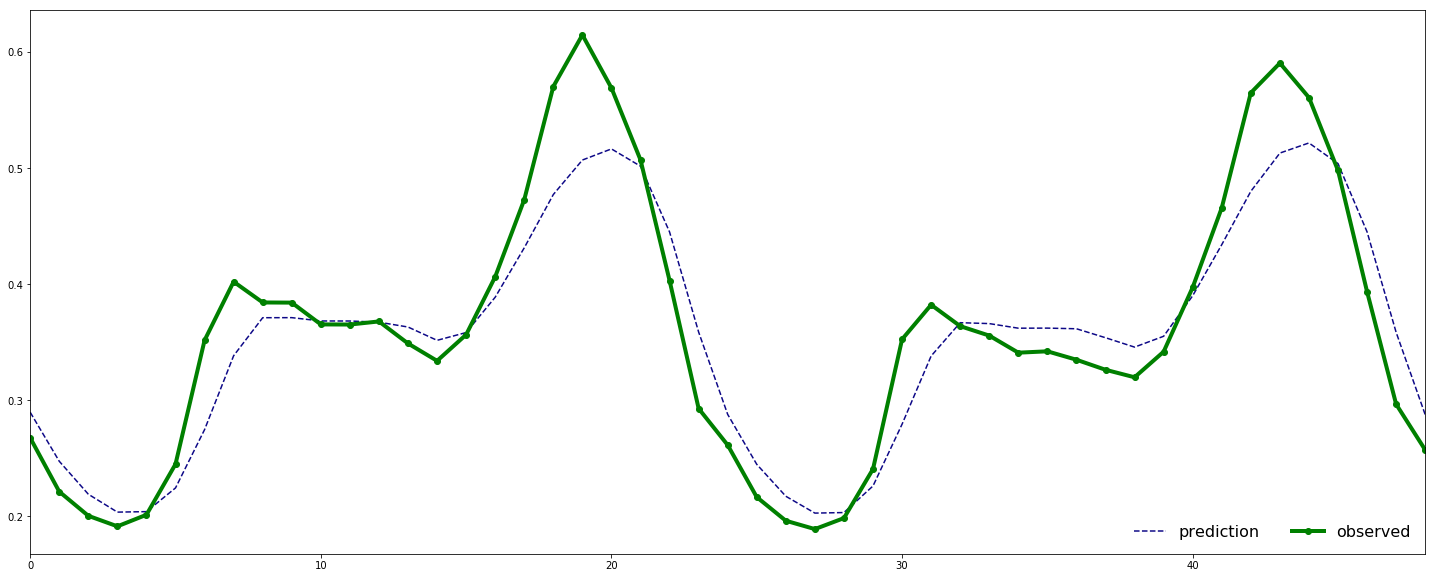

In [42]:
## assignment
real = test_y.to_numpy()
guess = ypred
real = real[30:31,:49]
guess = guess[30:31,:49]
rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()

### TPOT_ 1/10

In [15]:
from tpot import TPOTRegressor
from tpot_mulr import mul_reg_config_dict
from sklearn.model_selection import train_test_split
#import mul_config as mc## import multioutput regressor customized configuration

train_X, val_X, train_y, val_y = train_test_split(ahead_w, ahead_e, train_size = 0.1, test_size = 0.9, random_state = 321)
train_X.shape


(1399, 49)

In [16]:
tpot_reg = TPOTRegressor(generations=20, 
                         population_size=50, 
                         n_jobs=6, 
                         verbosity=2, 
                         random_state=321,  
                         config_dict=mul_reg_config_dict)

tpot_reg.fit(train_X , train_y)

Generation 1 - Current best internal CV score: -0.008183837657221294
Generation 2 - Current best internal CV score: -0.007770781828238729
Generation 3 - Current best internal CV score: -0.007770781828238729
Generation 4 - Current best internal CV score: -0.007391150058672738
Generation 5 - Current best internal CV score: -0.007391150058672738
Generation 6 - Current best internal CV score: -0.007287791645403237
Generation 7 - Current best internal CV score: -0.007287791645403237
Generation 8 - Current best internal CV score: -0.007287791645403237
Generation 9 - Current best internal CV score: -0.007238874860324926
Generation 10 - Current best internal CV score: -0.007238874860324926
Generation 11 - Current best internal CV score: -0.007238874860324926
Generation 12 - Current best internal CV score: -0.007238874860324926
Generation 13 - Current best internal CV score: -0.007193725520515469
Generation 14 - Current best internal CV score: -0.007105469488818179
Generation 15 - Current best 

TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ])},
                           'sklear

In [26]:
#val_X, val_y = train.iloc[500:600,:8], ahead_e.iloc[500:600,:]
yhat = tpot_reg.predict(test_X)

### Result Evaluation

In [35]:
get_eval(test_y, yhat)

MSE: 0.0032722146976264187
MAE: 0.044141697123933996
r2_score: 0.7561149660108636


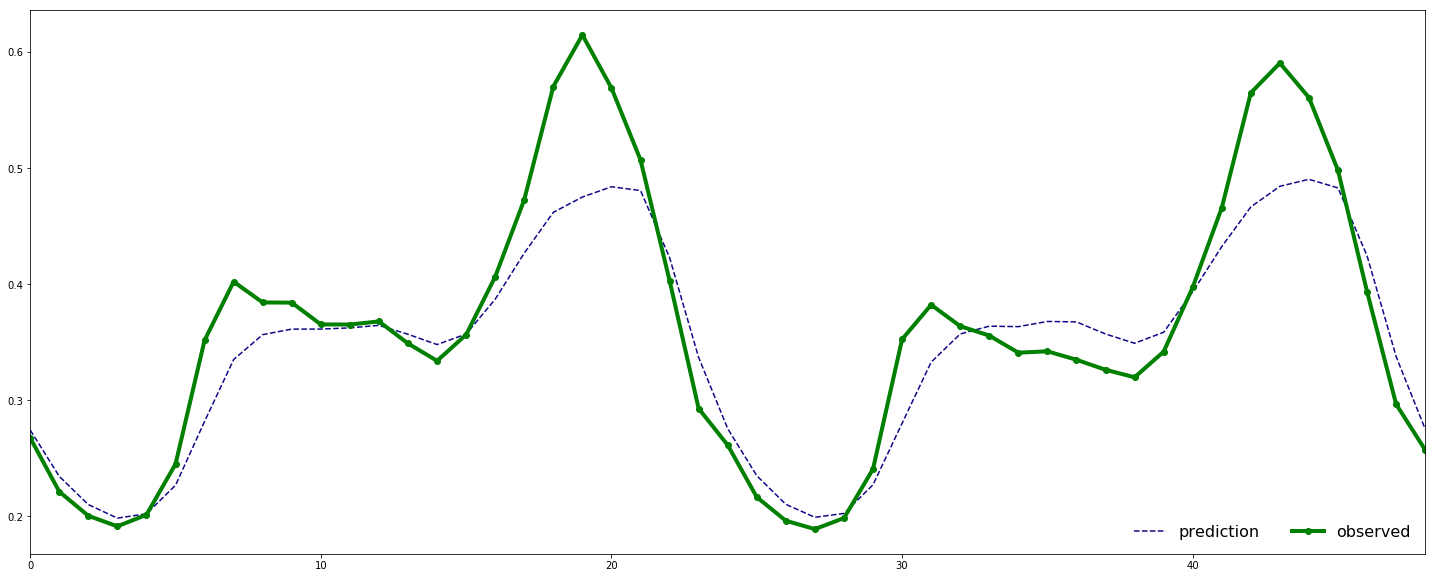

In [38]:
## assignment
real = test_y.to_numpy()
guess = yhat
real = real[30:31,:49]
guess = guess[30:31,:49]
rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()